# Assignment 2: Imaging Pipeline

MIDS W281: Computer Vision

## Recommended Libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob

## Part 1: Demosaicing

![Bayer Pattern](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/bayer_pattern.png)

### Overview
In this exercise you will convert a raw sensor image into a full color image using demosaicing. Digital sensors record color images through a Bayer mosaic (above), where each pixel records only one of the three color colors (RGB). A software interpolation is then needed to reconstruct all three colors at each pixel.

**HINT:** There are different Bayer mosaic patterns than the one shown above.  You should look into them and try them out.

### Description:
We will provide you with some raw images, represented as grayscale images (red, green, and blue pixels are all on the same channel of the image). Your task is to write some python code to demosaic and generate a full three-channel RGB image. You're encouraged to debug your code using the image `signs-small.png` because it is not very large and exhibits some interesting challenges of demosaicing. Note that you may need to convert images between `UINT8` and `float32` data types for computation and visualization.

For simplicity we will ignore the pixels at the boundary of the image, specifically the first and last two rows and columns don't need to be reconstructed. This will allow you to focus on the general case and not worry about whether neighboring values are unavailable. It's actually not uncommon for cameras and software to return a slightly-cropped image for similar reasons. Therefore, for an image of size NxN, you will return a cropped image of size (N-2)x(N-2)x3.  

1. Write a python function that takes as input a raw image and offset and returns a single-channel 2-D image corresponding to the interpolated green channel. The offset encodes whether either the top-left pixel or its right neighbor is the first green pixel. In our Figure 1 example, the second pixel is green, so offset=1.  

2. Write another python function for generating the red and blue channels. This function takes a raw image and two offsets: one for row offset and one for column offset, and returns a single-channel image. The row/column offset for the red channel is (0,0) and for the blue channel (1,1) for the Figure 1 example, but that might not be the case for the signs images (see hint). Note that the interpolation for the red/blue channel will be different than the green channel because the recorded pixels are sparser. For interpolated pixels that have two direct neighbors that are known (left-right or up-down), simply take the linear average between the two values. For the remaining case, average the four diagonal pixels. You can ignore the first and last two rows or columns to make sure that you have all the neighbors you need. Similar to the green-channel, interpolate the values when they are missing and copy the values when they are available.  

3. Using the above two functions, create a full three-channel, RGB image. You might observe some checkerboard artifacts around strong edges. This is expected from our naive interpolation approach.

### Deliverables:
- Python code for interpolation of green channel and red/blue channel
- Full-three channel RGB image for `signs.png` (**THE BIG ONE, NOT THE SMALL ONE**)

Data type: float32
Min value: 0.0
Max value: 1.0


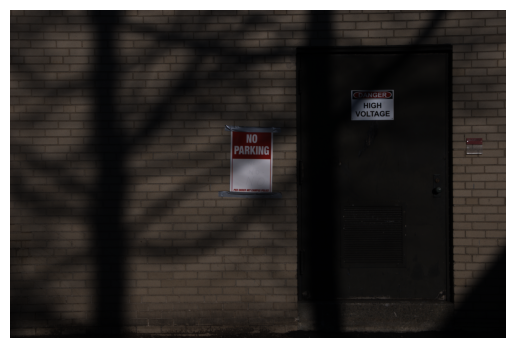

In [5]:
def interpolate_green(raw_img, offset_value):
    H, W = raw_img.shape
    green_img = np.zeros((H, W), dtype=np.float32)

    for r in range(2, H - 2):
        for c in range(2, W - 2):
            if ((r + c) % 2) == offset_value:
                green_img[r, c] = raw_img[r, c]
            else:
                left_is_green  = ((r + (c-1)) % 2) == offset_value
                right_is_green = ((r + (c+1)) % 2) == offset_value
                if left_is_green and right_is_green:
                    green_img[r, c] = 0.5 * (raw_img[r, c-1] + raw_img[r, c+1])
                else:
                    green_img[r, c] = 0.5 * (raw_img[r-1, c] + raw_img[r+1, c])
    return green_img

def interpolate_redblue(raw_img, offset_pair):
    (r_off, c_off) = offset_pair
    H, W = raw_img.shape
    rb_img = np.zeros((H, W), dtype=np.float32)

    for r in range(2, H - 2):
        for c in range(2, W - 2):
            if ((r % 2) == r_off) and ((c % 2) == c_off):
                rb_img[r, c] = raw_img[r, c]
            else:
                left_known  = ((r % 2) == r_off) and (((c-1) % 2) == c_off)
                right_known = ((r % 2) == r_off) and (((c+1) % 2) == c_off)
                up_known    = (((r-1) % 2) == r_off) and ((c % 2) == c_off)
                down_known  = (((r+1) % 2) == r_off) and ((c % 2) == c_off)

                if left_known and right_known:
                    rb_img[r, c] = 0.5 * (raw_img[r, c-1] + raw_img[r, c+1])
                elif up_known and down_known:
                    rb_img[r, c] = 0.5 * (raw_img[r-1, c] + raw_img[r+1, c])
                else:
                    rb_img[r, c] = 0.25 * (raw_img[r-1, c-1] +
                                           raw_img[r-1, c+1] +
                                           raw_img[r+1, c-1] +
                                           raw_img[r+1, c+1])
    return rb_img


# load images
test_img = plt.imread('./demosaicing/signs-small.png')
raw_img = plt.imread('./demosaicing/signs.png')

img = raw_img.copy()
# TODO: check img data type
print(f'Data type: {img.dtype}')
print(f'Min value: {img.min()}')
print(f'Max value: {img.max()}')
green_offset = 1
red_offset   = (1, 1)
blue_offset  = (0, 0)

green_img = interpolate_green(img, green_offset)


blue_img = interpolate_redblue(img, blue_offset)


red_img = interpolate_redblue(img, red_offset)

# Crop the images to ignore boundaries
r_crop = red_img[2:-2, 2:-2]
g_crop = green_img[2:-2, 2:-2]
b_crop = blue_img[2:-2, 2:-2]

# Stack into an RGB image
color_img = np.dstack([r_crop, g_crop, b_crop])
plt.imsave('demosaicing.png', color_img)
plt.imshow(color_img)
plt.axis('off')  # Hide axis
plt.show()

## Part 2: Denoising

![Denoising Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/denoising.png)

### Overview
Random noise is a problem that often arises in cameras specially in extremely low light conditions, and its presence can seriously degrade the quality of a digital image. To remedy the situation, an average of multiple images, captured very close in time, can be used to improve the quality final image. Because the camera may move while recording mulitple images, we will need to align the images before averaging and denoising. We will implement this alignment + denoising algorithm.

### Description:
We provide 18 images captured in a low light setting. One of the images is shown above.

Each image is slightly mis-aligned from the previous image in the sequence. Our goal is to align each of the images in the sequence to the first image and then average the aligned images to reduce the noise (which tends to be independent across images). Note that you may need to convert images between `UINT8` and `float32` data types for computation and visualization.

1. Write a python function that takes as input two images and returns the horizontal and vertical offset that best aligns the two images. Ignore the difference for all the pixels less than or equal to a `maxOffset` away from the edges. Use a brute force approach that tries every possible integer translation and evaluates the quality of a match using the squared error norm (the sum of the squared pixel differences). You can set the `maxOffset` to 15 pixels.  
2. Align each image to the first image and denoise by averaging all of the aligned images.


### Deliverables:

- Python code to align noisy images
- Aligned and de-noised average image

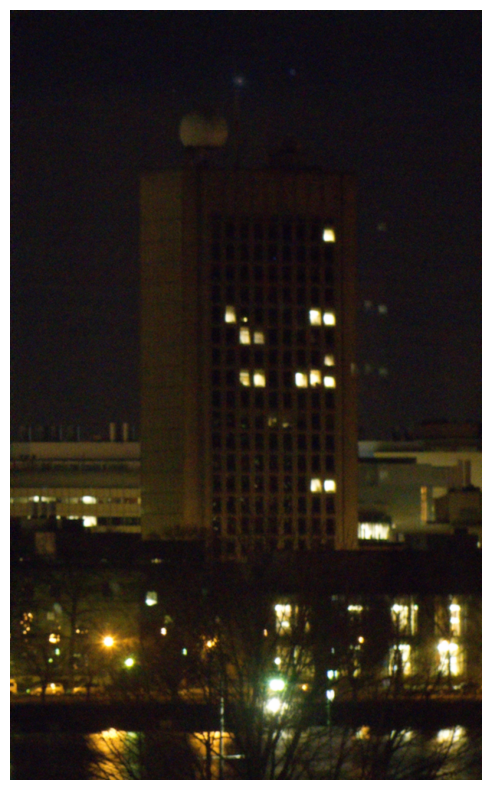

Denoised color image saved to denoised_average_color.png


"\nplt.axis('off')\nplt.figure(figsize = (20,10))\nplt.imshow(composite_img)\nplt.show()\n"

In [3]:
# TODO: use a for-loop to load remaining images and check data types

def align_imgs(img1_gray: np.ndarray, img_list: list[np.ndarray], maxOffset: int) -> tuple[list[tuple[int, int]], list[np.ndarray]]:
    # TODO: use nested for-loops to compute the error for every possible
    # combination of x and y offsets, up to the maxOffset in each dimension
    # The function np.roll may be helpful for shifting the images relative to each other
    # For each offset, compute the squared error norm
    def rgb2gray_inline(img: np.ndarray) -> np.ndarray:
        if img.ndim == 3 and img.shape[2] >= 3:
            return 0.2989 * img[:, :, 0] + 0.5870 * img[:, :, 1] + 0.1140 * img[:, :, 2]
        return img

    offsets = [(0, 0)]  # No offset for the reference image
    aligned_images = [img1_gray]
    H, W = img1_gray.shape

    for img_color in img_list[1:]:
        img2_gray = rgb2gray_inline(img_color)

        best_offset = (0, 0)
        best_error = float('inf')
        valid_margin = maxOffset
        img1_valid = img1_gray[valid_margin:H - valid_margin, valid_margin:W - valid_margin]

        for dy in range(-maxOffset, maxOffset + 1):
            for dx in range(-maxOffset, maxOffset + 1):
                shifted_img = np.roll(img2_gray, shift=(dy, dx), axis=(0, 1))

                if dy > 0:
                    shifted_img[:dy, :] = 0
                elif dy < 0:
                    shifted_img[dy:, :] = 0
                if dx > 0:
                    shifted_img[:, :dx] = 0
                elif dx < 0:
                    shifted_img[:, dx:] = 0

                img2_valid = shifted_img[valid_margin:H - valid_margin, valid_margin:W - valid_margin]
                error = np.sum((img1_valid - img2_valid) ** 2)

                if error < best_error:
                    best_error = error
                    best_offset = (dx, dy)

        offsets.append(best_offset)
        aligned_images.append(img2_gray)

    return offsets, aligned_images

def combine_imgs(img_list: list[np.ndarray], offset_list: list[tuple[int, int]]) -> np.ndarray:
    # TODO: for each image, shift it by the corresponding offset from align_imgs
    # Compute the mean across all offset images
    # Note that you do not need to make an array containing all images
    # It is computationally cheaper to add the weighted pixel values to a running sum image
    H, W, C = img_list[0].shape
    sum_img = np.zeros((H, W, C), dtype=np.float32)
    weight_img = np.zeros((H, W), dtype=np.float32)

    for img, (dx, dy) in zip(img_list, offset_list):
        shifted_img = np.roll(img, shift=(dy, dx), axis=(0, 1))

        if dy > 0:
            shifted_img[:dy, :, :] = 0
        elif dy < 0:
            shifted_img[dy:, :, :] = 0
        if dx > 0:
            shifted_img[:, :dx, :] = 0
        elif dx < 0:
            shifted_img[:, dx:, :] = 0

        sum_img += shifted_img
        weight_mask = np.any(shifted_img > 0, axis=2)
        weight_img += weight_mask.astype(np.float32)

    weight_img_safe = np.where(weight_img == 0, 1, weight_img)
    weight_img_safe_expanded = np.expand_dims(weight_img_safe, axis=2)
    composite_img = sum_img / weight_img_safe_expanded
    composite_img = np.where(weight_img_safe_expanded == 0, 0, composite_img)
    return composite_img

# TODO: for each image in img_list, compute best_offset using align_imgs
# Use the resulting offset list to generate a composite image
# Define the directory containing the images
image_directory = "./denoising"
image_pattern = os.path.join(image_directory, "*.png")
img_files = sorted(glob(image_pattern))
if not img_files:
    raise FileNotFoundError(f"No images found in the directory {image_directory} with pattern '*.png'.")

img_ref_color = plt.imread(img_files[0])
img_ref_gray = (0.2989 * img_ref_color[:, :, 0] + 0.5870 * img_ref_color[:, :, 1] +
                0.1140 * img_ref_color[:, :, 2] if img_ref_color.ndim == 3 else img_ref_color)
img_ref_gray = img_ref_gray.astype(np.float32) * (255.0 if img_ref_gray.max() <= 1.0 else 1.0)

img_list = []
for img_path in img_files:
    img_color = plt.imread(img_path).astype(np.float32)
    if img_color.shape[-1] == 4:  # Convert RGBA to RGB
        img_color = img_color[:, :, :3]
    if img_color.max() <= 1.0:
        img_color *= 255.0
    img_list.append(img_color)

max_offset = 15


offset_list, aligned_grays = align_imgs(img_ref_gray, img_list, max_offset)
composite_img = combine_imgs(img_list, offset_list)

composite_img_clipped = np.clip(composite_img, 0, 255).astype(np.uint8)

plt.figure(figsize=(20, 10))
plt.imshow(composite_img_clipped)
plt.axis('off')
plt.show()

output_path = ("denoised_average_color.png")
plt.imsave(output_path, composite_img_clipped)
print(f"Denoised color image saved to {output_path}")
'''
plt.axis('off')
plt.figure(figsize = (20,10))
plt.imshow(composite_img)
plt.show()
'''

## Part 3: White balance

Before WB

![WB Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/white_balance/input.png)

After WB

![WB Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/white_balance/output.png)

### Overview
Color constancy is one of the most amazing features of the human visual system. When we look at objects under different illuminations, their colors stay relatively constant. This helps humans to more easily identify objects under varying illuminations. A similar behavior is highly desirable in digital still and video cameras. This is achieved via white balancing, typically employed in a digital camera's imaging pipeline to adjust the coloration of images captured under different illuminations.

### Description
You will implement two methods for white balancing, gray-world and white-patch, described below. The two images above show before and after white balancing using the gray-world assumption. You can test your white balancing code using this example image. Images which are white-balanced using the white-patch method will have a different appearance depending on the patch selected.

1. One simple technique for white balancing is based on the gray-world assumption. This assumption argues that the average reflectance of a scene is achromatic. In other words, the mean of the red, green, and blue channels in a given scene should be roughly equal. We will implement this white balancing technique. Write a function to automatically white balance an image using the gray-world assumption. You should multiply each color channel by a scale factor so that the resulting mean of each of the three color channels is the same and equal to the average value of the green channel of the input image.

2. Another method for white balancing uses a white-patch in the image. In this method, the user manually selects an image region which is supposed to be white but looks colored due to the scene illumination. As above, we will scale each color channel by a factor so that the average color of the selected region becomes white. Write a python code to implement the white-patch balancing method. Your code should take in a location in the image and use a fixed-sized region around that point to compute the target white point.  You will know your output is correct if things that are supposed to be white look more white (e.g. clouds).

In both cases, you will need to account for pixel values that fall outside the displayable range after transformation. You should clip these values rather than scaling them.

Please specify the region that you selected in your code for 2.

### Deliverables:

- Python functions for gray-world and white-patch white balancing
- Output images after white balancing the image `white_balance/input.png` using both gray-world and white-patch methods

Original Image Data Type: float32
Original Image Min Pixel Value: 0.0
Original Image Max Pixel Value: 1.0
Converted RGBA to RGB.
Image is already in [0, 1] range.


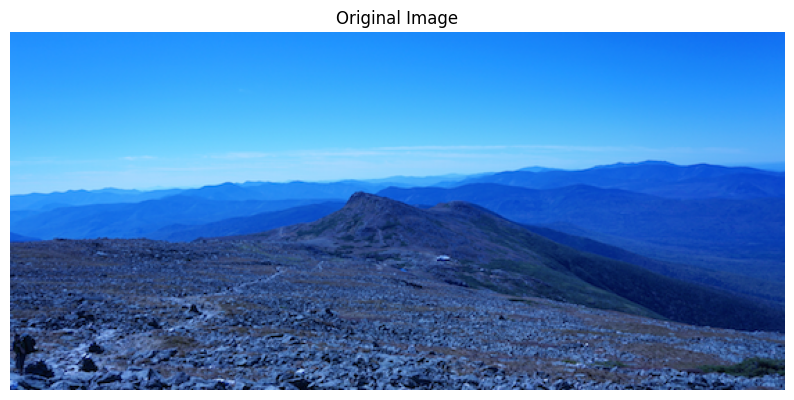


Applying Gray-World White Balancing...
Gray-World Scaling Factors: scale_r = 2.1760, scale_b = 0.6207
Selected White-Patch Center: (x=279, y=129)

Applying White-Patch White Balancing...
White-Patch Selected Region: x=(254-304), y=(104-154)
White-Patch Scaling Factors: scale_r = 7.3156, scale_g = 3.0591, scale_b = 1.5845


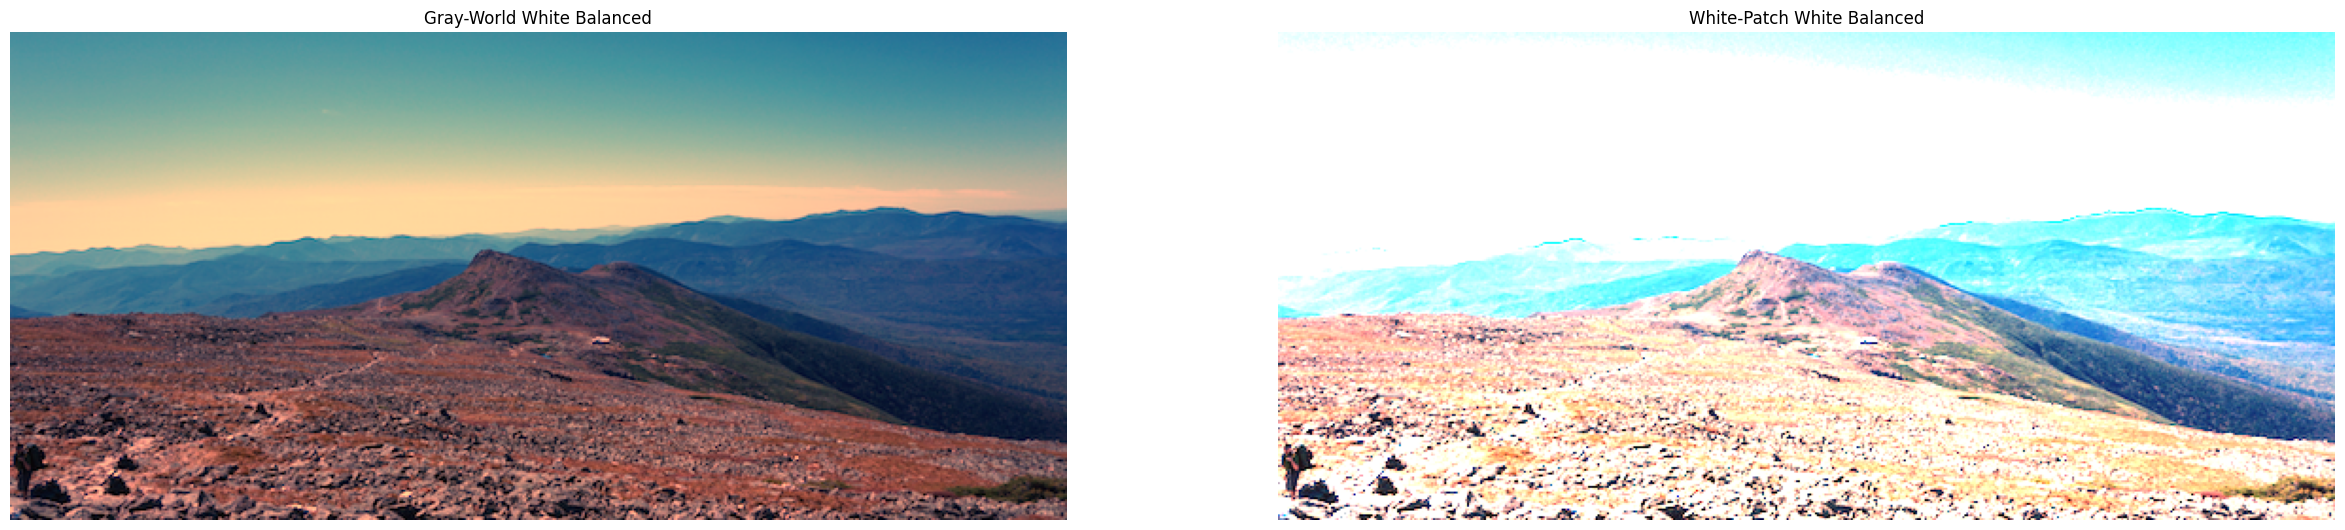


Gray-World white-balanced image saved to ./white_balance\gray_world_output.png
White-Patch white-balanced image saved to ./white_balance\white_patch_output.png


In [4]:
# TODO: check img data type

def gray_world(input_img):
    # TODO: get average green value
    # compute scale factor for red and blue
    # rescale red and blue channels
    """
    Automatically white balances an image using the gray-world assumption.
    The mean of the red and blue channels are scaled to match the mean of the green channel.

    Parameters:
    - input_img (np.ndarray): Input image as a 3D NumPy array (H x W x C) with pixel values in [0, 1].

    Returns:
    - wb_img (np.ndarray): White-balanced image as a 3D NumPy array (H x W x C) with pixel values in [0, 1].
    """
    # Compute the mean of each channel
    avg_r = np.mean(input_img[:, :, 0])
    avg_g = np.mean(input_img[:, :, 1])
    avg_b = np.mean(input_img[:, :, 2])

    # Compute scale factors for red and blue channels
    scale_r = avg_g / avg_r if avg_r != 0 else 1.0
    scale_b = avg_g / avg_b if avg_b != 0 else 1.0

    # Debug: Print scale factors
    print(f"Gray-World Scaling Factors: scale_r = {scale_r:.4f}, scale_b = {scale_b:.4f}")

    # Create a copy of the image to avoid modifying the original
    wb_img = input_img.copy()

    # Scale the red and blue channels
    wb_img[:, :, 0] *= scale_r
    wb_img[:, :, 2] *= scale_b

    # Clip the pixel values to [0, 1]
    wb_img = np.clip(wb_img, 0, 1)

    return wb_img

def white_patch(input_img, center_x, center_y, patch_size=50):
    # TODO: get point(s) from user
    # compute scale factors for each color channel
    # rescale each color channel
    """
    White balances an image using the white-patch method based on a selected region.

    Parameters:
    - input_img (np.ndarray): Input image as a 3D NumPy array (H x W x C) with pixel values in [0, 1].
    - center_x (int): X-coordinate of the center of the selected white patch.
    - center_y (int): Y-coordinate of the center of the selected white patch.
    - patch_size (int): Size of the square patch (default is 50).

    Returns:
    - wb_img (np.ndarray): White-balanced image as a 3D NumPy array (H x W x C) with pixel values in [0, 1].
    """
    half_patch = patch_size // 2
    H, W, _ = input_img.shape

    # Define the patch boundaries, ensuring they are within image dimensions
    x_start = max(center_x - half_patch, 0)
    x_end = min(center_x + half_patch, W)
    y_start = max(center_y - half_patch, 0)
    y_end = min(center_y + half_patch, H)

    # Extract the patch
    patch = input_img[y_start:y_end, x_start:x_end, :]

    # Compute the average color of the patch
    avg_r = np.mean(patch[:, :, 0])
    avg_g = np.mean(patch[:, :, 1])
    avg_b = np.mean(patch[:, :, 2])

    # Compute scale factors to make the patch white
    scale_r = 1.0 / avg_r if avg_r != 0 else 1.0
    scale_g = 1.0 / avg_g if avg_g != 0 else 1.0
    scale_b = 1.0 / avg_b if avg_b != 0 else 1.0

    # Debug: Print scale factors and patch location
    print(f"White-Patch Selected Region: x=({x_start}-{x_end}), y=({y_start}-{y_end})")
    print(f"White-Patch Scaling Factors: scale_r = {scale_r:.4f}, scale_g = {scale_g:.4f}, scale_b = {scale_b:.4f}")

    # Create a copy of the image to avoid modifying the original
    wb_img = input_img.copy()

    # Scale each channel
    wb_img[:, :, 0] *= scale_r
    wb_img[:, :, 1] *= scale_g
    wb_img[:, :, 2] *= scale_b

    # Clip the pixel values to [0, 1]
    wb_img = np.clip(wb_img, 0, 1)

    return wb_img

# Define the directory containing the images
image_directory = "./white_balance"

# Read the input image
input_img = plt.imread('./white_balance/input.png')

# Debug: Print image properties
print(f"Original Image Data Type: {input_img.dtype}")
print(f"Original Image Min Pixel Value: {input_img.min()}")
print(f"Original Image Max Pixel Value: {input_img.max()}")

# Ensure the image has 3 channels (RGB)
if input_img.ndim == 3:
  if input_img.shape[2] == 4:
      # Convert RGBA to RGB by dropping the alpha channel
      input_img = input_img[:, :, :3]
      print("Converted RGBA to RGB.")
  elif input_img.shape[2] == 3:
      # Image is already RGB
      print("Image is already in RGB format.")
  else:
      raise ValueError(f"Unsupported number of channels: {input_img.shape[2]} in image {img_files[0]}")
elif input_img.ndim == 2:
  # Convert grayscale to RGB by stacking the grayscale channel three times
  input_img = np.stack((input_img,)*3, axis=-1)
  print("Converted Grayscale to RGB by stacking channels.")
else:
  raise ValueError(f"Unsupported image shape: {input_img.shape} for image {img_files[0]}")

# Determine if the image is already in [0, 1] or [0, 255]
if input_img.dtype == np.uint8:
  input_img = input_img.astype(np.float32) / 255.0
  print("Scaled image from [0, 255] to [0, 1].")
elif input_img.dtype in [np.float32, np.float64]:
  if input_img.max() > 1.0:
      input_img = input_img.astype(np.float32) / 255.0
      print("Scaled image from [0, 255] to [0, 1].")
  else:
      input_img = input_img.astype(np.float32)
      print("Image is already in [0, 1] range.")
else:
  raise ValueError(f"Unsupported image data type: {input_img.dtype}")

# Display Original Image
plt.figure(figsize=(10, 10))
plt.imshow(input_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Apply Gray-World White Balancing
print("\nApplying Gray-World White Balancing...")
gray_world_output = gray_world(input_img)

# Define the center of the white patch

center_x = input_img.shape[1] // 2
center_y = input_img.shape[0] // 2
print(f"Selected White-Patch Center: (x={center_x}, y={center_y})")

# Apply White-Patch White Balancing
print("\nApplying White-Patch White Balancing...")
white_patch_output = white_patch(input_img, center_x, center_y, patch_size=50)

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

axes[0].imshow(gray_world_output)
axes[0].set_title('Gray-World White Balanced')
axes[0].axis('off')

axes[1].imshow(white_patch_output)
axes[1].set_title('White-Patch White Balanced')
axes[1].axis('off')

plt.show()

# Save the output images
output_dir = image_directory
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

plt.imsave(os.path.join(output_dir, 'gray_world_output.png'), gray_world_output)
plt.imsave(os.path.join(output_dir, 'white_patch_output.png'), white_patch_output)

print(f"\nGray-World white-balanced image saved to {os.path.join(output_dir, 'gray_world_output.png')}")
print(f"White-Patch white-balanced image saved to {os.path.join(output_dir, 'white_patch_output.png')}")

#### Acknowledgments
This assignment is based on an assignment for Computational Aspects of Digital Photography class by Prof. Wojciech Jarosz at Dartmouth College.